In [27]:
# Import necessary libraries, frameworks and modules
import os
import torch
import numpy as np
import pandas as pd
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [28]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using cuda device.


In [29]:
# Read and create the train and test dataframes
test_df = pd.read_csv('titanic/test.csv')
train_df = pd.read_csv('titanic/train.csv')


print('Train dataframe: ') 
display(train_df.head()) # 891 rows × 12 columns
print('Test dataframe: ')
display(test_df.head()) # 418 rows × 11 columns

Train dataframe: 


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Test dataframe: 


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [20]:
# Drop the irrelevant columns from the train and test dataframes
irr_cols = ['PassengerId', 'Name', 'Ticket']

train_data = train_df.drop(irr_cols, axis=1) # 891 rows × 9 columns
test_data = test_df.drop(irr_cols, axis=1) # 418 rows × 8 columns

display(train_data.head()) # columns: Pclass, Sex, Age, SibSp, Parch, Fare, Cabin, Embarked, Survived
display(test_data.head()) # columns: Pclass, Sex, Age, SibSp, Parch, Fare, Cabin, Embarked

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,34.5,0,0,7.8292,NaN,Q
1,3,female,47.0,1,0,7.0000,NaN,S
2,2,male,62.0,0,0,9.6875,NaN,Q
3,3,male,27.0,0,0,8.6625,NaN,S
4,3,female,22.0,1,1,12.2875,NaN,S


In [30]:
# Preprocess the data
def preprocess_data(df):
    # Convert categorical columns to numeric
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col].astype(str))

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    return df

# Apply preprocessing
train_data = preprocess_data(train_df.drop(irr_cols, axis=1))
test_data = preprocess_data(test_df.drop(irr_cols, axis=1))

# Split the data into features and labels
train_labels = train_data['Survived']
train_features = train_data.drop('Survived', axis=1)
test_features = test_data

# Normalize the data
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

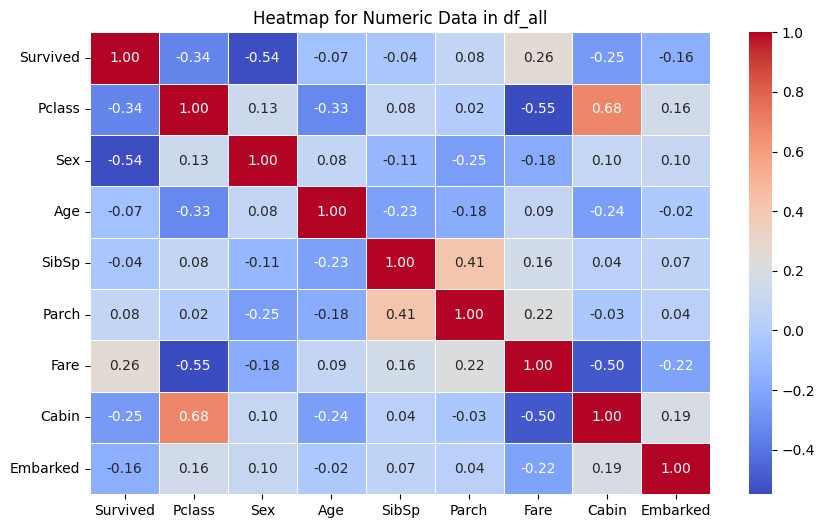

In [31]:
numeric_columns = train_data.select_dtypes(include='number')

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
heatmap_data = numeric_columns.corr()  # Calculate correlation matrix
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap for Numeric Data in df_all')
plt.show()

In [22]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.6),  
            nn.Linear(128, 1)  # Output layer for binary classification
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Determine the number of feature columns
num_features = train_features.shape[1]

# Create the model instance
model = NeuralNetwork(num_features).to(device)

In [32]:
def train_loop(dataloader, model, loss_fn, optimizer, l1_lambda=1e-5, isTrain=True):
    size = len(dataloader.dataset)
    total_loss = 0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        pred = torch.squeeze(pred)
        loss = loss_fn(pred, y)

        # L1 Regularization
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss = loss + l1_lambda * l1_norm

        total_loss += loss.item()

        # Calculate accuracy
        predicted_labels = (pred > 0).type(torch.int)
        correct += (predicted_labels == y).type(torch.float).sum().item()

        # Backpropagation
        if isTrain:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            model.val()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    average_loss = total_loss / size
    accuracy = correct / size
    print(f"Average loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")

# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [24]:
# Convert DataFrame to tensor
train_features_tensor = torch.tensor(train_features.astype(np.float32))
train_labels_tensor = torch.tensor(train_labels.values.astype(np.float32))

# Create a dataset
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [33]:
# Define the number of epochs
num_epochs = 32

# Train the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)

print("Training done!")

Epoch 1
-------------------------------
loss: 0.512916  [    0/  891]
Average loss: 0.0061, Accuracy: 0.8462
Epoch 2
-------------------------------
loss: 0.410535  [    0/  891]
Average loss: 0.0059, Accuracy: 0.8530
Epoch 3
-------------------------------
loss: 0.387348  [    0/  891]
Average loss: 0.0059, Accuracy: 0.8530
Epoch 4
-------------------------------
loss: 0.324722  [    0/  891]
Average loss: 0.0058, Accuracy: 0.8586
Epoch 5
-------------------------------
loss: 0.272079  [    0/  891]
Average loss: 0.0057, Accuracy: 0.8620
Epoch 6
-------------------------------
loss: 0.268921  [    0/  891]
Average loss: 0.0057, Accuracy: 0.8620
Epoch 7
-------------------------------
loss: 0.318486  [    0/  891]
Average loss: 0.0057, Accuracy: 0.8541
Epoch 8
-------------------------------
loss: 0.284097  [    0/  891]
Average loss: 0.0056, Accuracy: 0.8575
Epoch 9
-------------------------------
loss: 0.287954  [    0/  891]
Average loss: 0.0056, Accuracy: 0.8608
Epoch 10
----------

In [26]:
# Convert test_features to a tensor and move it to the same device as the model
test_features_tensor = torch.tensor(test_features).float().to(device)

# Predict using the model
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    predictions = model(test_features_tensor)
    predictions = torch.sigmoid(predictions)  # Apply sigmoid to get probabilities
    predicted_labels = (predictions > 0.5).int().squeeze()  # Convert to binary predictions

# Convert predictions to a NumPy array and then to a list
predicted_labels = predicted_labels.cpu().numpy().tolist()

# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': predicted_labels
})

# Create the submission CSV file
submission_file = "sumbission.csv"
submission_df.to_csv(submission_file, index=False)

print(f"Submission file '{submission_file}' created successfully.")


Submission file 'sumbission.csv' created successfully.
